# Hackathon #2

Written by Eleanor Quint

Topics: 
- Dense layers
- Gradient descent optimization
- Training by minibatch/gradient step and epoch
- TensorBoard

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

### A First Attempt at Classifying MNIST

MNIST is a dataset of greyscale 28x28 handwritten digits labelled 0 through 9. We'll use it for a 10-class problem to learn the basics of classification.

Let's have a look at the data first. We'll load the data from [Tensorflow Datasets](https://www.tensorflow.org/datasets) and visualize it with matplotlib's `plt.imshow`.

data shape: (32, 28, 28, 1)
label: tf.Tensor([3 4 5 8 9 4 8 7 2 5 1 2 9 9 9 0 8 2 3 5 7 7 9 5 7 8 2 6 1 3 5 7], shape=(32,), dtype=int64)
An image looks like this:
It's colored because matplotlib wants to provide more contrast than just greys


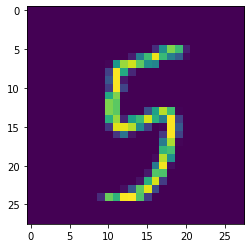

In [2]:
ds = tfds.load('mnist', shuffle_files=True) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

# Looping through the iterator, each batch is a dict
for batch in train_ds:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx])
print("It's colored because matplotlib wants to provide more contrast than just greys")

The first step to building a simple neural network is to specify layers. The most basic building block is the dense layer (AKA linear layer or fully connected layer), so we'll declare a function that creates the layer. Each dense layer is composed of two variables, the weight matrix `W` and the bias vector `b` as well as a non-linear activation function `a`, to calculate the function `f(x) = a(Wx + b)`.

Normally we'll use pre-defined layers, but in this notebook we'll do it ourselves first to better understand what's going on under the hood.

In [3]:
class Dense(tf.Module):
    def __init__(self, output_size, activation=tf.nn.relu):
        """
        Args:
            - output_size: (int) number of neurons
            - activation: (function) non-linear function applied to the output
        """
        self.output_size = output_size
        self.activation = activation
        self.is_built = False
        
    def _build(self, x):
        data_size = x.shape[-1]
        self.W = tf.Variable(tf.random.normal([data_size, self.output_size]), name='weights')
        self.b = tf.Variable(tf.random.normal([self.output_size]), name='bias')
        self.is_build = True

    def __call__(self, x):
        if not self.is_built:
            self._build(x)
        return self.activation(tf.matmul(x, self.W) + self.b)

The first dimension of the input is the "batch" dimension, which allows us to run many data through the model simultaneously. The matrix `W` has a row for each input dimension so that each column corresponds to the weights of one linear unit of the layer. After adding the bias vector to the vector resulting from the vector-matrix multiplication, we activate with a non-linearity.

Let's define a simple, two layer network with this function. We activate the first layer with the rectified linear function [`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu), but not the second layer so that we can interpret its output as the [logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) of a discrete probability distribution. Note that we're going to flatten the data into a vector (784 = 28 x 28) so that we can use it with a linear layer (we encountered `tf.reshape` in the last hackathon). Loss is calculated with [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy), which implies that we're interpreting the output of the neural network as the paramters of a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution).

100%|██████████| 1875/1875 [00:07<00:00, 257.10it/s]


Accuracy: 0.10141667


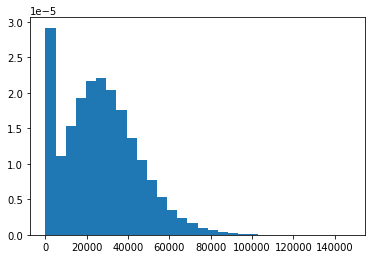

In [4]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784]) # -1 means everyting not otherwise accounted for
    labels = batch['label']
    x = first_layer(x)
    logits = second_layer(x)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss_values.append(loss)
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)

# print accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

Now let's re-declare the network with pre-defined layers using [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), group the layers using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), and training the parameters with the [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

Note how [`tf.GradientTape`](https://www.tensorflow.org/guide/autodiff) is used. We run all the computations which we want to backpropagate gradients through in the scope of the tape and then, after the loss is calculated, we can call `tape.gradient` to calculate the gradient of the output with respect to the model variables.

100%|██████████| 1875/1875 [00:06<00:00, 275.25it/s]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (32, 200)                 157000    
_________________________________________________________________
dense_5 (Dense)              (32, 10)                  2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.88488334


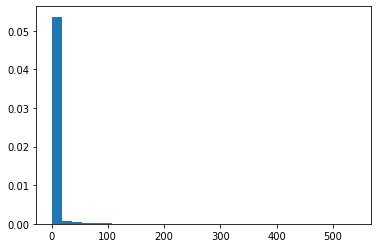

In [8]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    with tf.GradientTape() as tape:
        # run network
        x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
        labels = batch['label']
        logits = model(x)
    
        # calculate loss
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
    loss_values.append(loss)
    
    # gradient update
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

After one epoch of training the loss values drop dramatically and accuracy rises from change (\~10%) to that of a decent classifier (\~85-90%).

### Homework

Your homework is to specify a convolutional network with `tf.keras.layers`, train it on the cifar10 dataset (which you can get easily with TensorFlow datasets), and save the trained parameters to disk in the TensorFlow [Saved Model](https://www.tensorflow.org/guide/saved_model) format with the folder name "cifar10_model". Submit your trained model so that I can load it with `tf.saved_model.load("cifar10_model")` to evaluate it. (The trick is to find these things in the TF documentation. Once you've found the functions you need, the code should be very simple.)

### Coda

In [6]:
from IPython.display import HTML
# From Colah's Blog, linearly separating spirals with linear transforms and non-linearities
print("We want the blue and red lines to be linearly separable, so how does a neural network manage to do this?\
 Let's visualize the linear transformations and non-linearities.")
HTML('<img src="http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif">')

We want the blue and red lines to be linearly separable, so how does a neural network manage to do this? Let's visualize the linear transformations and non-linearities.
